In [55]:
import numpy as np
import os
import cv2
import pytesseract
import matplotlib.pyplot as plt
import matplotlib
import networkx as nx
import copy
from keras.models import load_model
from glue_lines import GlueLines
from lines_to_graph import LinesToGraph
from graph_to_smiles import GraphToSmiles

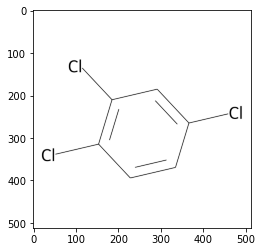

In [56]:
def create_filename(num: int) -> str:
    return str(num) + '.png'

FOLDER_NAME = '../images'

img_num = 12

img = cv2.imread(
    os.path.join(FOLDER_NAME, create_filename(img_num)),
    cv2.IMREAD_GRAYSCALE
)
img = cv2.bitwise_not(img)

plt.imshow(img, cmap='Greys')
plt.show()
dst = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
cdst = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)
cdst2 = cv2.cvtColor(dst, cv2.COLOR_GRAY2BGR)

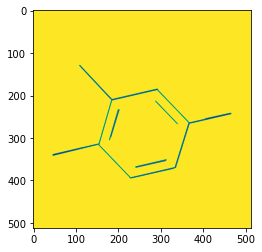

In [57]:
lines = cv2.HoughLinesP(image=dst, 
                        rho=1, 
                        theta=(np.pi / 180),
                        threshold=50,
                        lines=None,
                        minLineLength=45,
                        maxLineGap=5
)
lines = [line[0] for line in lines]
new_one = np.zeros([512, 512, 1], dtype=np.uint8)
new_one.fill(255)
for i, l in enumerate(lines):
    cv2.line(new_one, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 1, cv2.LINE_AA)
cv2.imwrite('../fst.png', new_one)
plt.imshow(new_one)
plt.show()

[[290 185 367 265]
 [365 266 465 243]
 [154 316 185 209]
 [184 210 292 185]
 [154 314  46 340]
 [227 394 335 369]
 [109 129 186 211]
 [153 315 229 394]
 [334 370 367 264]
 [179 305 202 233]
 [240 368 313 351]
 [287 213 339 267]]


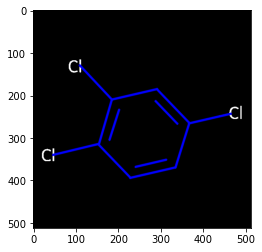

In [58]:
gl = GlueLines(lines)
needed_lines = gl.get_glued_lines()
print(needed_lines)
for l in needed_lines:
    cv2.line(cdst, (l[0], l[1]), (l[2], l[3]), (0, 0, 255), 3, cv2.LINE_AA)
plt.imshow(cdst)
plt.show()

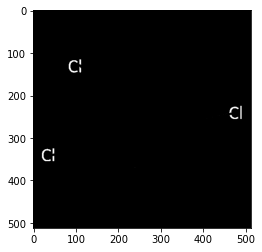

In [59]:
for l in needed_lines:
    cv2.line(cdst2, (l[0], l[1]), (l[2], l[3]), (0, 0, 0), 3, cv2.LINE_AA)
cv2.imwrite('../snd.png', cdst2)
plt.imshow(cdst2)
plt.show()

(512, 512, 3)
3
height: 30, width: 29
height: 31, width: 29
height: 31, width: 29


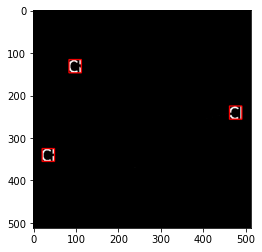

In [60]:
def is_to_union(rect1, rect2, threshold):
    return (rect2[0][0] <= rect1[1][0] + threshold and
           rect2[0][1] <= rect1[1][1] + threshold and
           rect1[0][1] <= rect2[1][1] + threshold)

def union_rectangles(rectangles, threshold=10):
    rectangles = sorted(rectangles, key=lambda rec: rec[0][0])
    unioned = [False] * len(rectangles)
    new_rectangles = []
    for i, cur_rect in enumerate(rectangles):
        if not unioned[i]:
            for j in range(i + 1, len(rectangles)):
                if is_to_union(cur_rect, rectangles[j], threshold):
                    cur_rect = [(cur_rect[0][0], 
                                 min(cur_rect[0][1], rectangles[j][0][1])), 
                                (max(cur_rect[1][0], rectangles[j][1][0]), 
                                 max(cur_rect[1][1], rectangles[j][1][1]))]
                    unioned[j] = True
            unioned[i] = True
            new_rectangles.append(cur_rect)
    return new_rectangles


cdst3 = copy.copy(cdst2)
threshold_area = 40
print(cdst3.shape)
black_cdst3 = cv2.cvtColor(cdst3, cv2.COLOR_BGR2GRAY)
letters, _ = cv2.findContours(black_cdst3, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
#print(len(letters))
rectangles = []
for letter in letters:
    (left, top, width, height) = cv2.boundingRect(letter)
    if width * height >= threshold_area:
        tl = (left, top)
        br = (left + width, top + height)
        rectangles.append([tl, br])
        #cdst2 = cv2.rectangle(cdst2, tl, br, (0, 0, 255), 1)
new_rectangles = union_rectangles(rectangles)
for rect in new_rectangles:
    cdst3 = cv2.rectangle(cdst3, rect[0], rect[1], (255, 0, 0), 2)
print(len(new_rectangles))
for rect in new_rectangles:
    print(f'height: {rect[1][1] - rect[0][1]}, width: {rect[1][0] - rect[0][0]}')
cv2.imwrite('../thd.png', cdst3)
plt.imshow(cdst3)
plt.show()

In [61]:
model = load_model('../letter_to_group.h5')

In [62]:
vect_of_nums = ['P', '', '0', 'Cl', 'C', 'F', 'N', 'Br', 'B',
                'T', 'O', 'S']
def get_group(rect):
    cur_img = cdst2[rect[0][1]:rect[1][1], rect[0][0]:rect[1][0]]
    width = rect[1][0] - rect[0][0]
    height = rect[1][1] - rect[0][1]
    img_size = max(width, height) 
    sqared_img = np.zeros(shape=(img_size, img_size, 3))
    w_indent = (img_size - width) // 2
    h_indent = (img_size - height) // 2
    sqared_img[h_indent:(h_indent + height), w_indent:(w_indent + width)] = cur_img
    saving_img = cv2.resize(sqared_img, (32, 32), interpolation=cv2.INTER_AREA)
    saving_img = saving_img.astype('float32')
    saving_img = cv2.cvtColor(saving_img, cv2.COLOR_BGR2GRAY)
    saving_img /= 255
    saving_img = saving_img.reshape((1, 32, 32, 1))
    ans = model.predict([saving_img])
    it = np.argmax(ans[0])
    return vect_of_nums[it]

groups = []
for rect in new_rectangles:
    letter = get_group(rect)
    if letter != '' and letter != 'T':
        groups.append([rect, letter])
print(groups)

[[[(21, 325), (50, 355)], 'Cl'], [[(84, 116), (113, 147)], 'Cl'], [[(461, 225), (490, 256)], 'Cl']]


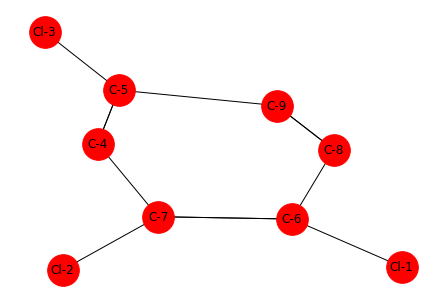

In [63]:
ltg = LinesToGraph(needed_lines, groups)
graph = ltg.make_graph()
nodes = ltg.get_nodes()
for node in nodes:
    cdst = cv2.rectangle(cdst, node[0], node[1], (255, 0, 0), 2)
cv2.imwrite('../fou.png', cdst)
#plt.imshow(cdst)
#plt.show()
nx.draw(graph, node_color='red', node_size=1000, with_labels=True)
plt.savefig("fit.png")

In [54]:
gts = GraphToSmiles(graph)
print(gts.get_smiles())

C1=C(Cl)C=CC(=C1Cl)Cl
